# Vertical Line Test

## 1.1 Create two graphs, one that passes the vertical line test and one that does not.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Passes the vertical line test

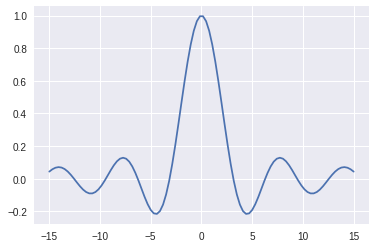

In [5]:
x = np.linspace(-15,15,100) # 100 linearly spaced numbers
y = np.sin(x)/x # computing the values of sin(x)/x

plt.plot(x,y) # sin(x)/x
plt.show()

Does not pass vertical line test

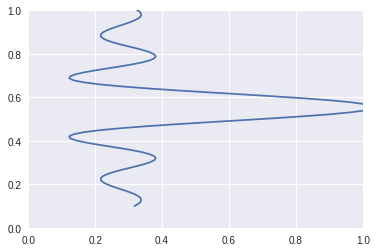

In [24]:
# Source: 
# https://stackoverflow.com/questions/22540449/how-can-i-rotate-a-matplotlib-plot-through-90-degrees

from matplotlib import transforms

x = np.linspace(-15,15,100) # 100 linearly spaced numbers
y = np.sin(x)/x # computing the values of sin(x)/x

# first of all, the base transformation of the data points is needed
#base = plt.gca().transData # this rotates the base... but can use without it
rot = transforms.Affine2D().rotate_deg(-90)

plt.plot(x,y, transform= rot+base) # must include 'base' along with rot

plt.show()

## 1.2 Why are graphs that don't pass the vertical line test not considered "functions?"

Definition of a function: Every x value has a unique y value.

Think about it If any particular x value has 2 different y values , then a vertical line will intersect the at two different places.

Read more: https://www.mathwarehouse.com/algebra/relation/vertical-line-test.php#ixzz5c95sVg82

# Functions as Relations

## 2.1 Which of the following relations are functions? Why?

\begin{align}
\text{Relation 1: } \{(1, 2), (3, 2), (1, 3)\}
\\
\text{Relation 2: } \{(1, 3), (2, 3), (6, 7)\}
\\
\text{Relation 3: } \{(9, 4), (2, 1), (9, 6)\}
\\
\text{Relation 4: } \{(6, 2), (8, 3), (6, 4)\}
\\
\text{Relation 5: } \{(2, 6), (2, 7), (2, 4)\}
\end{align}

> Only **Relation 2** is a function. Its x-values have unique y-values.

# Functions as a mapping between dimensions


## 3.1 for the following functions what is the dimensionality of the domain (input) and codomain (range/output)?

\begin{align}
m(𝑥_1,𝑥_2,𝑥_3)=(x_1+x_2, x_1+x_3, x_2+x_3)
\\
n(𝑥_1,𝑥_2,𝑥_3,𝑥_4)=(x_2^2 + x_3, x_2x_4)
\end{align}

> m function = 3 dimensions for domain & 3 dimensions for co-domain

> n function = 4 dimensions for dmail & 2 dimensions for co-domain

## 3.2 Do you think it's possible to create a function that maps from a lower dimensional space to a higher dimensional space? If so, provide an example.

# Vector Transformations


## 4.1 Plug the corresponding unit vectors into each function. Use the output vectors to create a transformation matrix.

\begin{align}
p(\begin{bmatrix}x_1 \\ x_2 \end{bmatrix}) = \begin{bmatrix} x_1 + 3x_2 \\2 x_2 - x_1 \\  \end{bmatrix}
\\
\\
q(\begin{bmatrix}x_1 \\ x_2 \\ x_3\end{bmatrix}) = \begin{bmatrix} 4x_1 + x_2 + 2x_3 \\2 x_2 - x_1 + 3x_3 \\ 5x_1 - 2x_3 + x_2  \end{bmatrix}
\end{align}

In [26]:
x_1 = np.array([1, 0])
x_2 = np.array([0, 1])
x = np.array([1, 3])
y = np.array([2, -1])
t = np.array([[1, 3], [2, -1]]); t
rand = np.array([1, 3])
p1 = x_1 * x
print(p1)
p2 = x_2 * y
print(p2)

[1 0]
[ 0 -1]


In [27]:
t = np.array([[1, 0], [0, -1]]) ; t

array([[ 1,  0],
       [ 0, -1]])

## 4.2 Verify that your transformation matrices are correct by choosing an input matrix and calculating the result both via the traditional functions above and also via vector-matrix multiplication.

# Eigenvalues and Eigenvectors

## 5.1 In your own words, give an explanation for the intuition behind eigenvalues and eigenvectors.

**Eigenvectors**: unit vectors that remain in the line they span even after a transformation is perform.

**Eigenvalues**: coefficient that gives the eigenvector's length or magnitude

# The Curse of Dimensionality

## 6.1 What are some of the challenges of working with high dimensional spaces?

- Easy to overfit ML model
- Hard understand relationship between variables

## 6.2 What is the rule of thumb for how many observations you should have compared to parameters in your model?

You should always make sure that you have 5 times the number of observations as you have parameters in your model.

# Principal Component Analysis

## 7.1 Load the UCI Machine Learning Repository's [Iris Dataset](https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/d546eaee765268bf2f487608c537c05e22e4b221/iris.csv) and use PCA to isolate the dataset's first and second principal components and plot them on a graph. 

In [0]:
df = pd.read_csv('https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/d546eaee765268bf2f487608c537c05e22e4b221/iris.csv')

In [53]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [59]:
df.species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [0]:
df2 = df.iloc[:,0:4]

In [0]:
pca = PCA(2)
# create the PCA instance
pca.fit(df2)
# access values and vectors
print("\n Eigenvectors: \n", pca.components_)
print("\n Eigenvalues: \n", pca.explained_variance_)
#transform data
B = pca.transform(df2)
print("\n Projected Data: \n", B)

In [0]:
scaler = StandardScaler()
scaler.fit(df2)
scaled_data = scaler.transform(df2)

pca = PCA(n_components=2)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

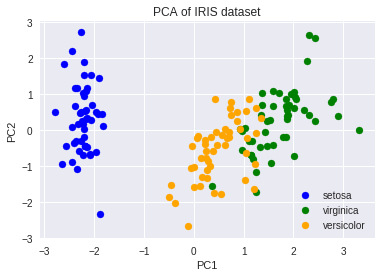

In [90]:
y = df['species']
y_labels = ['setosa', 'virginica', 'versicolor']
colors = ['blue', 'green', 'orange']

fig_pca, ax_pca = plt.subplots()

ax_pca.set_title('PCA of IRIS dataset')

for color, label in zip(colors, y_labels):
    ax_pca.scatter(x_pca[:,0][y==label], x_pca[:,1][y==label], c=color, label=label)

    
ax_pca.set_xlabel('PC1')
ax_pca.set_ylabel('PC2')

ax_pca.legend()

plt.show()

In [36]:
from sklearn.datasets import load_iris
iris = load_iris()

df1 = pd.DataFrame(iris['data'], columns=iris['feature_names'])
df1.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df1)
scaled_data = scaler.transform(df1)

pca = PCA(n_components=2)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

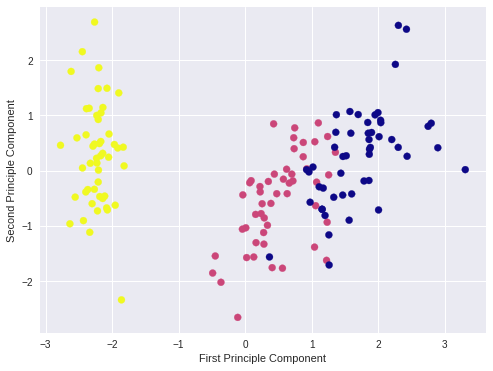

In [42]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=iris['target'], cmap='plasma_r')
plt.xlabel('First Principle Component')
plt.ylabel('Second Principle Component')
plt.show()

In [44]:
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [60]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

# Stretch Goal

## 1) Do NOT work on the stretch goal until you feel like you have a firm grasp of eigenvectors, eigenvalues, and PCA. Prioritize self-study over the stretch goal if you are not comfortable with those topics yet.

## 2) Explore further the intuition behind eigenvalues and eigenvectors by creating your very own eigenfaces:

<center>![Eigenfaces](https://i.pinimg.com/236x/1c/f1/01/1cf101a9859437a5d096a04b05be06b4--faces-tattoo.jpg)</center>

You don't necessarily have to use this resource, but this will get you started: 
[Eigenface Tutorial](https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/)